In [1]:
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.converter.fasta import fasta_to_sequence
from eden.graph import Vectorizer
from itertools import islice
import numpy as np
from scipy.sparse import vstack
%matplotlib inline
%load_ext memory_profiler
from bioinf_learn.util import measure_performance
from bioinf_learn.util import plotData

import time
import numpy as np

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2, nbits=10):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    seqs = islice(seqs,n_max)
    seqs = list(seqs)
    graphs = rnafold_to_eden(seqs)
    vectorizer = Vectorizer(complexity=complexity, nbits=nbits, positional=True)
    X = vectorizer.transform(graphs)
    return X

def rfam_data(rfam_ids, n_max=300, complexity=3, nbits=13):
    Xs = []
    targets = []
    for i,rfam_id in enumerate(rfam_ids):
        X=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity, nbits=nbits)
        Xs.append(X)
        targets += [i] * X.shape[0]
    data_matrix = vstack(Xs, format="csr")
    targets = np.array(targets)    
    return data_matrix, targets

In [2]:
rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

In [15]:
%%time
X, y = rfam_data(rfam_ids[:3], n_max=100, complexity=3, nbits=16)
print 'Instances: %d Features: %d with an avg of %d features per instance' % (X.shape[0], X.shape[1],  X.getnnz()/X.shape[0])
print "Sparsity: ", X.nnz / float(X.shape[0]) / X.shape[1]

Instances: 300 Features: 65537 with an avg of 3914 features per instance
Sparsity:  0.0597250916785
CPU times: user 9.02 s, sys: 2.52 s, total: 11.5 s
Wall time: 15.7 s


In [4]:
n_neighbors_sklearn = 10
n_neighbors_minHash = 10
returnValuesRNA = measure_performance(X, n_neighbors_sklearn, n_neighbors_minHash, 
                                        number_of_hashfunctions=[100, 200, 400, 600, 800, 1000], size_of_query=None)

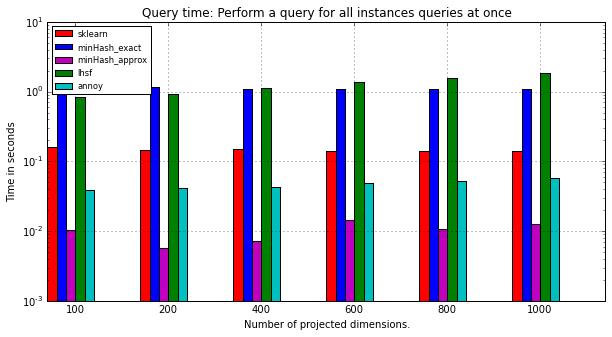

In [6]:
plotData(data=returnValuesRNA[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", number_of_instances=6,
        xlabel="Number of projected dimensions.",
         number_of_features=1, title='Query time: Perform a query for all instances queries at once')

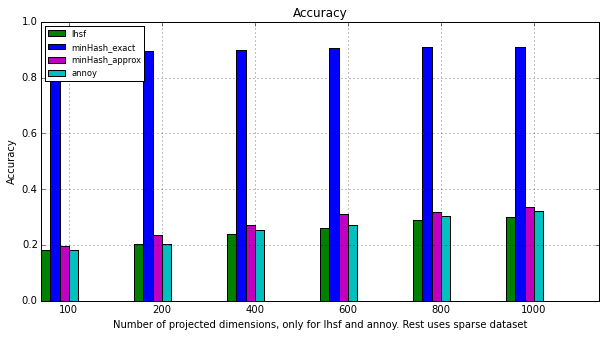

In [9]:
plotData(data=returnValuesRNA[9:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=6,
        number_of_features=1, title='Accuracy', log=False)

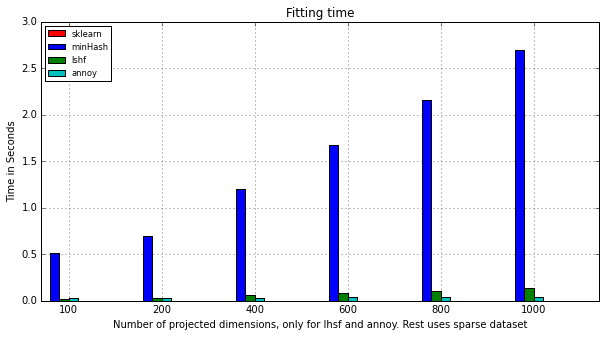

In [10]:
plotData(data=returnValuesRNA[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

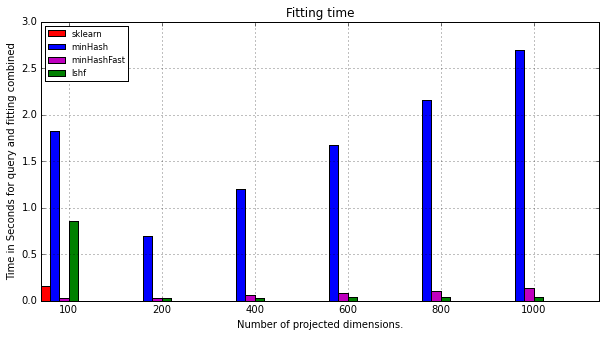

In [14]:
for i in xrange(4):
    
    if i !=2:
        returnValuesRNA[i+4][0] += returnValuesRNA[i][0]
    else:
        returnValuesRNA[i+4][0] += returnValuesRNA[i-1][0]
plotData(data=returnValuesRNA[:4], color=["r", "b","m", "g", "c"], label=["sklearn", "minHash", "minHashFast", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], 
         xlabel="Number of projected dimensions.",
         ylabel="Time in Seconds for query and fitting combined", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

---